# Import libraries

In [1]:
# for drive access
from google.colab import drive
drive.mount('/content/drive')

# standard libraries
from typing import Tuple, List, Dict, Literal
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

# use pydantic for parameter type checking
from pydantic import BaseModel, Field

# reduce the number of colors using KMeans Clustering
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min, silhouette_score, davies_bouldin_score, calinski_harabasz_score

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Define class method

In [2]:
class ProcessImageInput(BaseModel, extra="forbid"):
  """
    Parameters:
    - input_image_path (str): Path to the input image file.
    - resize_ratio (float): The ratio by which the image should be resized, must be > 0.
    - grid_size (int): The size of the grid for pixelation, must be > 0.
    - do_reduce (bool): Flag indicating whether to reduce colors.
    - cluster_metric (str): Method for identifying number of clusters. Ignored if do_reduce == False.
      - sil: silhouette
      - db: davies_bouldin
      - ch: calinski_harabasz
    - num_colors (int): Maximum number of colors to reduce to, must be >= 2. Ignored if do_reduce == False.

  """
  input_image_path: str
  resize_ratio: float = Field(default=0.1, gt=0)
  grid_size: int = Field(default=10, gt=0)
  do_reduce: bool = Field(default=False)
  cluster_metric: Literal['sil', 'db', 'ch'] = Field(default='ch')
  num_colors: int = Field(default=12, ge=2)

class Processed:
  def __init__(self,
               input_params: ProcessImageInput):
    """
    Instantiate the Processed class which processes the input image based on the specified parameters.

    Parameters:
    - input_params (ProcessImageInput): Input parameters defined by the ProcessImageInput Pydantic model.
    """
    self.input_image_path = input_params.input_image_path
    self.resize_ratio = input_params.resize_ratio
    self.grid_size = input_params.grid_size
    self.do_reduce = input_params.do_reduce
    self.cluster_metric = input_params.cluster_metric
    self.num_colors = input_params.num_colors

    self._process_image()

  ########################################
  # _process_image method is called when the class is instantiated
  ########################################
  def _process_image(self):
    """
    Process the input image based on the specified parameters.

    Parameters:
    - input_params (ProcessImageInput): Input parameters defined by the ProcessImageInput Pydantic model.
    """
    # load the original image
    self.original_image = Image.open(self.input_image_path)
    self.original_array = np.array(self.original_image)
    print('original shape: ', self.original_array.shape)

    # resize the image based on ratio parameter
    self.resized_image = self.resize_image(self.original_image, self.resize_ratio, self.grid_size)
    self.resized_array = np.array(self.resized_image)
    print('resized shape: ', self.resized_array.shape)
    print('resized image: ')
    display(self.resized_image)

    # pixelate the image
    self.image_pixelates = self.get_pixelates(self.resized_image, self.grid_size)
    self.predominant_colors = self.get_predominant(self.resized_image, self.image_pixelates)

    # display the processed image
    if not self.do_reduce:
      self.display_pixelated_image(self.resized_image, self.grid_size, self.image_pixelates)
    else:
      # dynatically call the x_method method to find the optimal number of clusters
      method = f"{self.cluster_metric}_method"
      if hasattr(self, method) and callable(func := getattr(self, method)):
        self.num_clusters = func(self.num_colors, self.predominant_colors)
        print('optimal_num_clusters: ', self.num_clusters)
      self.centroids = self.get_centroids(self.predominant_colors, self.num_clusters)
      self.predominant_color_mapping = self.get_predominant_color_mapping(self.predominant_colors, self.centroids)
      self.display_reduced_colors_image(self.resized_image, self.grid_size, self.image_pixelates, self.predominant_color_mapping, self.centroids)

  ########################################
  # resize_image method is called by the process_image method to resize the image
  ########################################
  def resize_image(self,
                   image: Image,
                   resize_ratio: float,
                   grid_size: int) -> Image:
    """
      Resize the given image based on the specified ratio and grid size.

      Parameters:
      - image (Image): The input image.
      - resize_ratio (float): The ratio by which the image should be resized.
      - grid_size (int): The size of the grid for ensuring divisibility.

      Returns:
      Image: The resized image.
    """
    width, height = image.size
    new_height = int(height * resize_ratio)
    new_width = int(width * resize_ratio)

    # ensure the new dimensions are divisible by grid_size
    new_height = (new_height // grid_size) * grid_size
    new_width = (new_width // grid_size) * grid_size
    new_size = (new_width, new_height)

    resized_image = image.resize(new_size)
    return resized_image

  ########################################
  # get_pixelates method is called by the process_image method to get pixelates of the image
  ########################################
  def get_pixelates(self,
                    image: Image,
                    grid_size: int) -> Dict[int, List]:
    """
      Pixelate the given image into a grid of the specified size.

      Parameters:
      - image (Image): The input image.
      - grid_size (int): The size of the grid for pixelation.

      Returns:
      Dict[int, List]: A dictionary representing the pixelated image grid,
                              with the key being the column index and the values
                              being a list of cropped images for each column index.
    """
    image_array = np.array(image)
    height, width, _ = image_array.shape
    newsize = (grid_size, grid_size)

    pixelates={}
    for col in range(0, width, grid_size):
      pixelates[col] = []
      for row in range(0, height, grid_size):
        cropped = image.crop((col, row, col+grid_size, row+grid_size))
        cropped = cropped.resize(newsize)
        pixelates[col].append(cropped)

    num_cols = len(pixelates.keys())
    num_rows = len(pixelates[0])
    print('num_cols: ', num_cols)
    print('num_rows: ', num_rows)

    return pixelates

  ########################################
  # display_pixelated_image method is called by the process_image method to display the pixelated image
  ########################################
  def display_pixelated_image(self,
                              image: Image,
                              grid_size: int,
                              pixelates: Dict[int, List]):
    """
      Display the pixelated image.

      Parameters:
      - image (Image): The original image.
      - grid_size (int): The size of the grid for pixelation.
      - pixelates (Dict[int, List]): Dictionary representing the pixelated image grid,
                                    as returned from the get_pixelates() method.
    """
    image_array = np.array(image)
    height, width, channels = image_array.shape

    # set figsize dimensions
    fig_width = int(width / grid_size) / 10 * 2
    fig_height = int(height / grid_size) / 10 * 2

    # get the dimensions of the subplot grid
    num_cols = len(pixelates.keys())
    num_rows = len(pixelates[0])

    # display the pixelated image
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(fig_width, fig_height))
    for col, key in enumerate(pixelates.keys()):
      col_imgs = pixelates[key]
      for row, each in enumerate(col_imgs):
        # replace all pixels in the grid with the predominant color
        each_array = np.array(each)
        unique_colors, counts = np.unique(each_array.reshape(-1, channels), axis=0, return_counts=True)
        predominant_color = unique_colors[np.argmax(counts)]
        each_array[:, :] = predominant_color
        axs[row, col].imshow(each_array)
        axs[row, col].axis('off')
    plt.show()

  ########################################
  # get_predominant method is called by the process_image method to get the predominant color for each grid
  ########################################
  def get_predominant(self,
                      image: Image,
                      pixelates: Dict[int, List]) -> List[np.ndarray]:
    """
      Get the predominant colors in each grid of the pixelated image.

      Parameters:
      - image (Image): The input image.
      - pixelates (Dict[int, List]): Dictionary representing the pixelated image grid,
                                    as returned from the get_pixelates() method.

      Returns:
      List[np.ndarray]: A list of predominant colors in each grid.
    """
    image_array = np.array(image)
    _, _, channels = image_array.shape

    predominant_colors=[]
    for key in pixelates.keys():
      col_imgs = pixelates[key]
      for each in col_imgs:
        each_array = np.array(each)
        unique_colors, counts = np.unique(each_array.reshape(-1, channels), axis=0, return_counts=True)
        predominant_color = unique_colors[np.argmax(counts)]
        predominant_colors.append(predominant_color)
    return predominant_colors

  ########################################
  # sil_method method is called by the process_image method to get the optiminal number of clusters using the silhouette method
  ########################################
  def sil_method(self,
                 cluster_range: int,
                 data: List[np.ndarray]) -> int:
    """
      Calculate the optimal number of clusters using the silhouette method.

      Parameters:
      - cluster_range (int): The range of clusters to consider.
      - data (List[np.ndarray]): The input data for clustering.

      Returns:
      int: The optimal number of clusters based on the silhouette method.
    """
    silhouette_scores = []
    for k in range(2, cluster_range + 1):
      kmeans = KMeans(n_clusters=k, n_init='auto', random_state=0)
      kmeans.fit(data)
      silhouette_scores.append(silhouette_score(data, kmeans.labels_))

    optimal_num_clusters = silhouette_scores.index(max(silhouette_scores)) + 2
    return optimal_num_clusters

  ########################################
  # db_method method is called by the process_image method to get the optiminal number of clusters using the davies_bouldin method
  ########################################
  def db_method(self,
                cluster_range: int,
                data: List[np.ndarray]) -> int:
    """
      Calculate the optimal number of clusters using the davies_bouldin method.

      Parameters:
      - cluster_range (int): The range of clusters to consider.
      - data (List[np.ndarray]): The input data for clustering.

      Returns:
      int: The optimal number of clusters based on the davies_bouldin method.
    """
    db_scores = []
    for k in range(2, cluster_range):
        kmeans = KMeans(n_clusters=k, n_init='auto', random_state=0)
        kmeans.fit(data)
        db_scores.append(davies_bouldin_score(data, kmeans.labels_))

    optimal_num_clusters = db_scores.index(min(db_scores)) + 2
    return optimal_num_clusters

  ########################################
  # ch_method method is called by the process_image method to get the optiminal number of clusters using the calinski_harabasz method
  ########################################
  def ch_method(self,
                cluster_range: int,
                data: List[np.ndarray]) -> int:
    """
      Calculate the optimal number of clusters using the calinski_harabasz method.

      Parameters:
      - cluster_range (int): The range of clusters to consider.
      - data (List[np.ndarray]): The input data for clustering.

      Returns:
      int: The optimal number of clusters based on the calinski_harabasz method.
    """
    calinski_harabasz_scores = []
    for k in range(2, cluster_range):
      kmeans = KMeans(n_clusters=k, n_init='auto', random_state=0)
      kmeans.fit(data)
      calinski_harabasz_scores.append(calinski_harabasz_score(data, kmeans.labels_))

    optimal_num_clusters = calinski_harabasz_scores.index(max(calinski_harabasz_scores)) + 2
    return optimal_num_clusters

  ########################################
  # get_centroids method is called by the process_image method to get the centroid colors
  ########################################
  def get_centroids(self,
                    predominant_colors: List[np.ndarray],
                    num_colors: int) -> np.ndarray:
    """
      Compute the centroids of predominant colors using k-means clustering.

      Parameters:
      - predominant_colors (List[np.ndarray]): List of predominant colors for each grid of an image,
                                              as returned from the get_predominant() method.
      - num_colors (int): Number of clusters (centroids) to find.

      Returns:
      np.ndarray: Array containing the centroids of the predominant colors.
    """
    predominant_colors_array = np.array(predominant_colors)

    # use k-means to find k centroid colors
    kmeans = KMeans(n_clusters=num_colors, random_state=0, n_init='auto')
    kmeans.fit(predominant_colors_array)
    centroids = kmeans.cluster_centers_
    print('centroids: ', centroids)

    # display the centroids
    centroids_image = np.zeros((1, len(centroids), 3), dtype=np.uint8)
    for i, centroid in enumerate(centroids):
      centroids_image[0, i, :] = centroid
    plt.imshow(centroids_image)
    plt.axis('off')
    plt.show()
    print()

    return centroids

  ########################################
  # get_predominant_color_mapping method is called by the process_image method to map the predominant colors to the centroids
  ########################################
  def get_predominant_color_mapping(self,
                                    predominant_colors: List[np.ndarray],
                                    centroids: np.ndarray) -> Dict[Tuple, int]:
    """
      Map each predominant color to its nearest centroid.

      Parameters:
      - predominant_colors (List[np.ndarray]): List of predominant colors for each grid of an image,
                                              as returned from the get_predominant() method.
      - centroids (np.ndarray): Array containing the centroids of the predominant colors,
                                as returned from the get_centroids() method.

      Returns:
      Dict[Tuple, int]: Mapping of predominant colors to their nearest centroid indices.
    """
    predominant_colors_array = np.array(predominant_colors)

    predominant_color_mapping = {}
    labels, _ = pairwise_distances_argmin_min(predominant_colors_array, centroids)
    for i, each in enumerate(predominant_colors_array):
      predominant_color_mapping[tuple(each)] = labels[i] # cast np.ndarray to hashable type tuple

    return predominant_color_mapping

  ########################################
  # display_reduced_colors_image method is called by the process_image method to display the pixelated image with only centroid colors
  ########################################
  def display_reduced_colors_image(self,
                                   image: Image,
                                   grid_size: int,
                                   pixelates: Dict[int, List],
                                   predominant_color_mapping: Dict[Tuple, int],
                                   centroids: np.ndarray):
    """
      Display the pixelated image with reduced colors.

      Parameters:
      - image (Image): The original image.
      - grid_size (int): The size of the grid for pixelation.
      - pixelates (Dict[int, List]): Dictionary representing the pixelated image grid,
                                    as returned from the get_pixelates() method.
      - predominant_color_mapping (Dict[Tuple, int]): Mapping of predominant colors to their nearest centroid indices,
                                                      as returned from the get_predominant_color_mapping() method.
      - centroids (np.ndarray): Array containing the centroids of the predominant colors,
                                as returned from the get_centroids() method.
    """
    image_array = np.array(image)
    height, width, channels = image_array.shape

    # set figsize dimensions
    fig_width = int(width / grid_size) / 10 * 2
    fig_height = int(height / grid_size) / 10 * 2

    # get the dimensions of the subplot grid
    num_cols = len(pixelates.keys())
    num_rows = len(pixelates[0])

    # display the pixelated image
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(fig_width, fig_height))
    for col, key in enumerate(pixelates.keys()):
      col_imgs = pixelates[key]
      for row, each in enumerate(col_imgs):
        # replace all pixels in the grid with the predominant color
        each_array = np.array(each)
        unique_colors, counts = np.unique(each_array.reshape(-1, channels), axis=0, return_counts=True)
        predominant_color = unique_colors[np.argmax(counts)]
        centroid = predominant_color_mapping[tuple(np.array(predominant_color))]
        each_array[:, :] = centroids[centroid]
        axs[row, col].imshow(each_array)
        axs[row, col].axis('off')
    plt.show()

# Miata

## output

original shape:  (2350, 3760, 3)
resized shape:  (234, 375, 3)
resized image: 


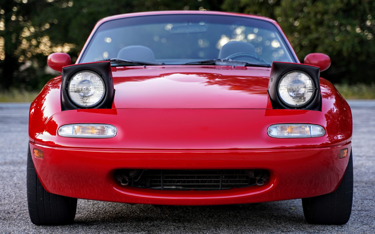

num_cols:  125
num_rows:  78
optimal_num_clusters:  5
centroids:  [[ 21.17881137  21.18165375  16.44005168]
 [ 88.84536082 102.01890034 130.26059565]
 [186.92665037 162.67155664 189.799511  ]
 [201.00176367  45.7292769   81.0308642 ]
 [142.46023689   8.07670615  14.97969543]]


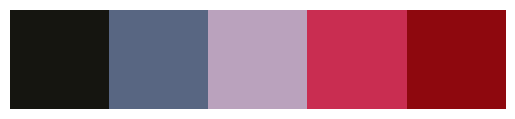

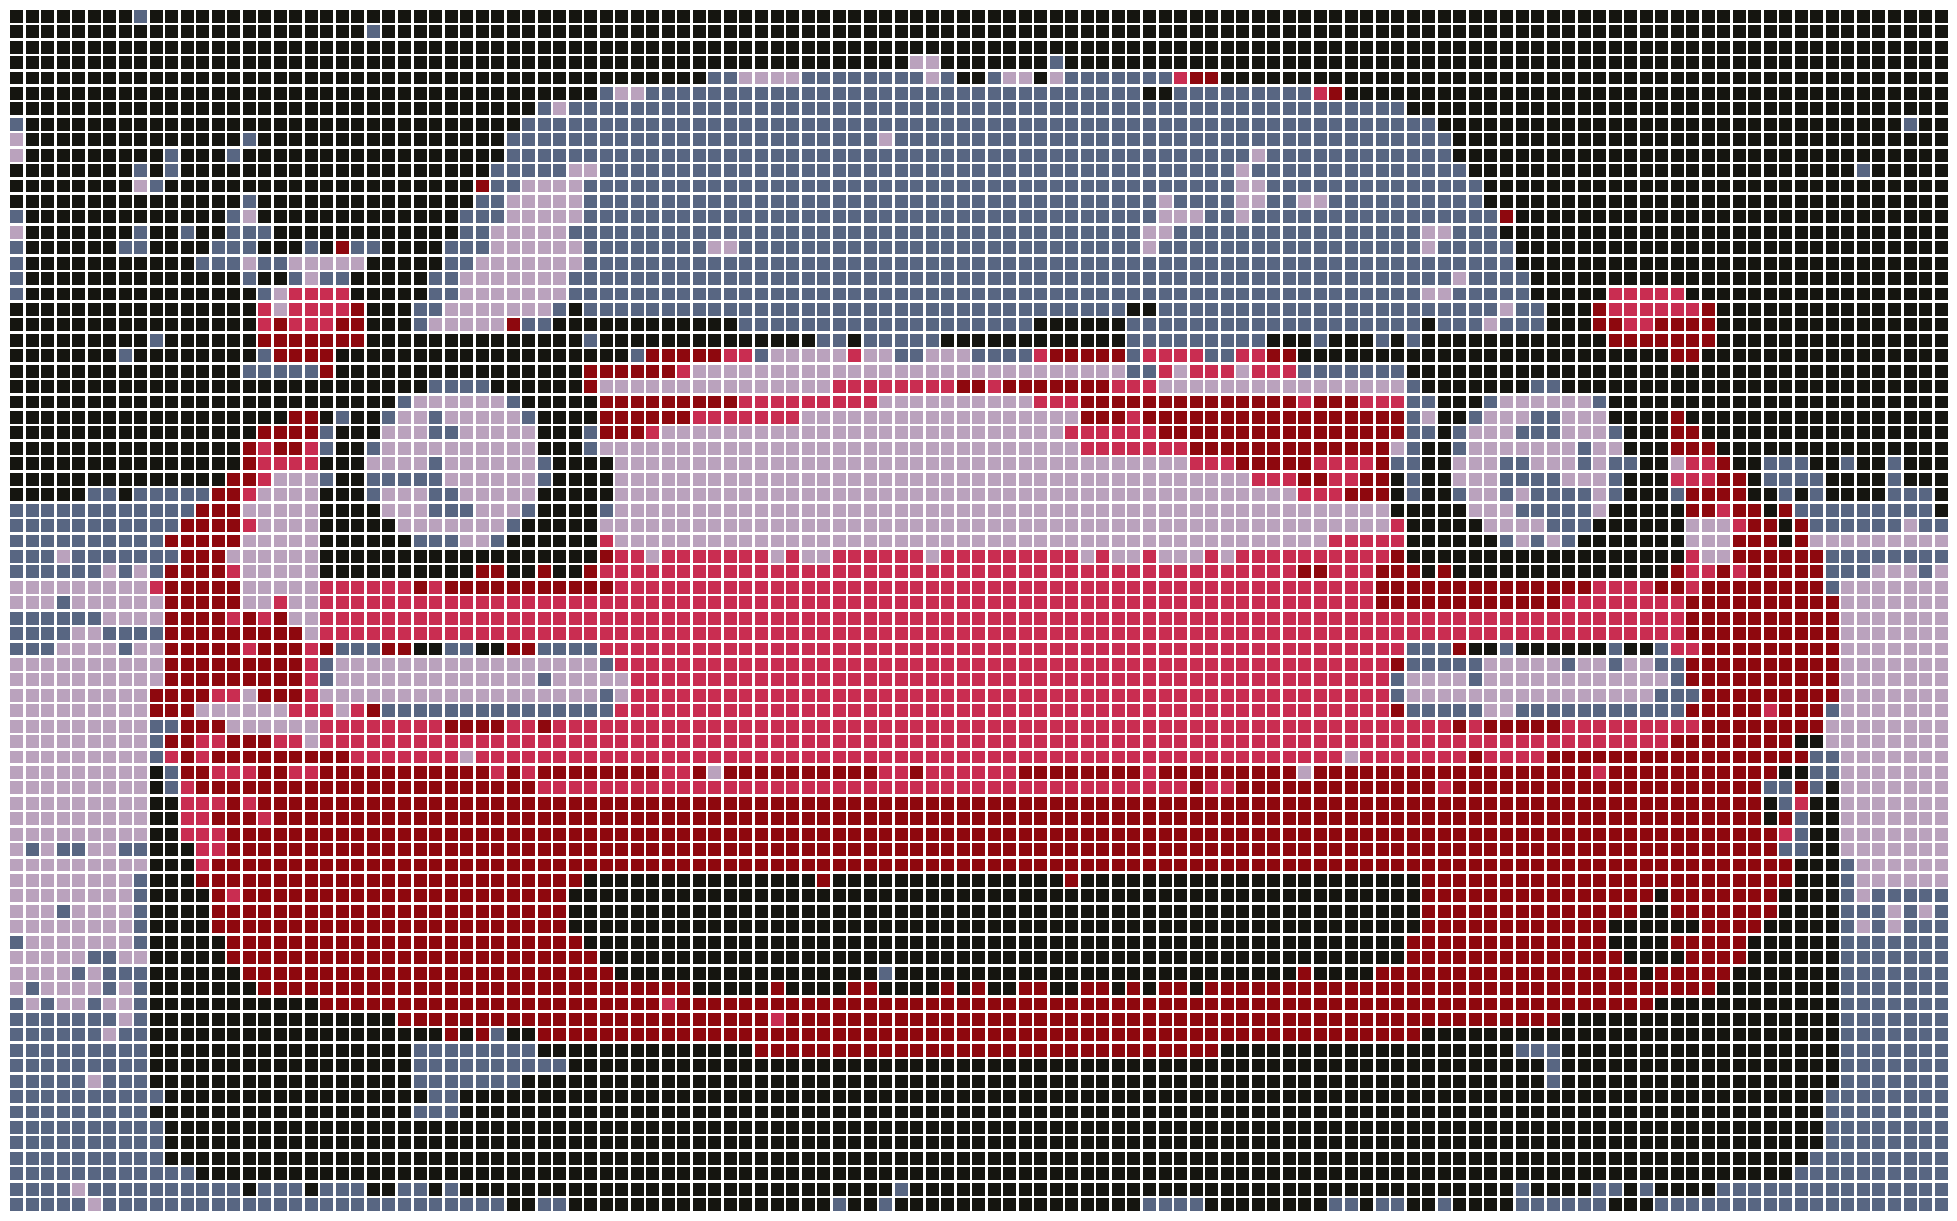

In [3]:
input_params = ProcessImageInput(input_image_path="/content/drive/MyDrive/Projects/pixelate/miata_for_blanket.jpg",
                                 resize_ratio=0.1,
                                 grid_size=3,
                                 do_reduce=True,
                                 num_colors=7)

processed = Processed(input_params)

## adjust the centroid colors based on available yarn colors

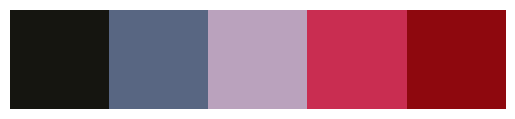

In [4]:
new_centroids = processed.centroids
new_centroids

centroids_image = np.zeros((1, len(new_centroids), 3), dtype=np.uint8)
for i, centroid in enumerate(new_centroids):
  centroids_image[0, i, :] = centroid
plt.imshow(centroids_image)
plt.axis('off')
plt.show()

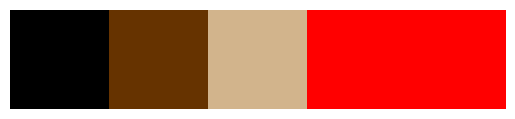

In [5]:
new_centroids[0] = [0,0,0] # black
new_centroids[1] = [102,51,0] # brown
new_centroids[2] = [210,180,140] # tan
new_centroids[3] = [255,0,0] # red
new_centroids[4] = [255,0,0] # red

centroids_image = np.zeros((1, len(new_centroids), 3), dtype=np.uint8)
for i, centroid in enumerate(new_centroids):
  centroids_image[0, i, :] = centroid
plt.imshow(centroids_image)
plt.axis('off')
plt.show()

### display the new image with new centroids

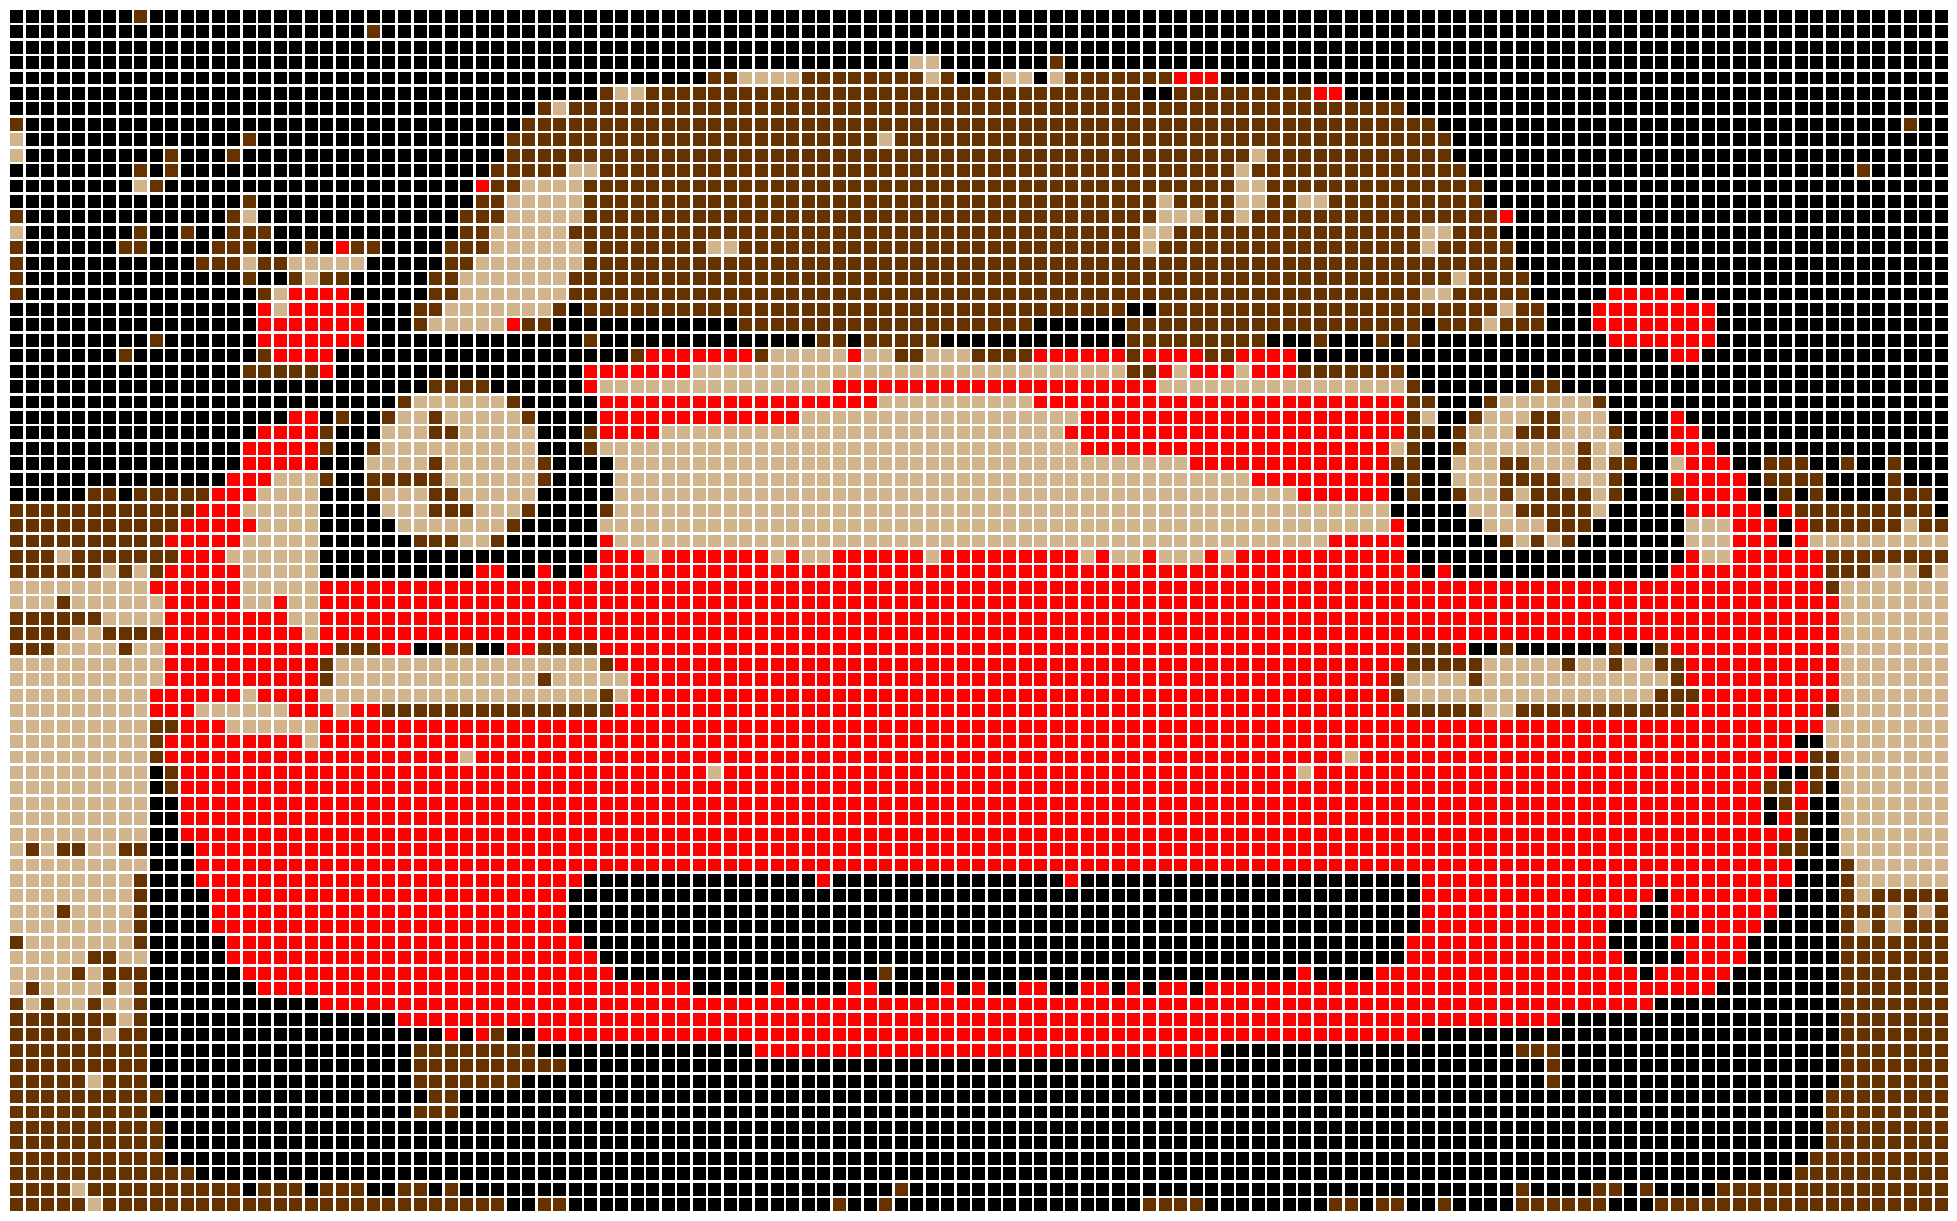

In [6]:
processed.display_reduced_colors_image(processed.resized_image,
                                       processed.grid_size,
                                       processed.image_pixelates,
                                       processed.predominant_color_mapping,
                                       new_centroids)

## try a different combination of colors

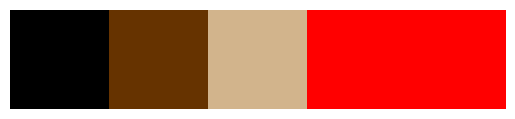

In [7]:
new_centroids = processed.centroids
new_centroids

centroids_image = np.zeros((1, len(new_centroids), 3), dtype=np.uint8)
for i, centroid in enumerate(new_centroids):
  centroids_image[0, i, :] = centroid
plt.imshow(centroids_image)
plt.axis('off')
plt.show()

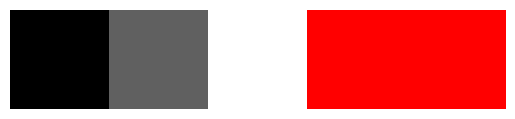

In [8]:
new_centroids[0] = [0,0,0] # black
new_centroids[1] = [96,96,96] # grey
new_centroids[2] = [255,255,255] # white
new_centroids[3] = [255,0,0] # red
new_centroids[4] = [255,0,0] # red

centroids_image = np.zeros((1, len(new_centroids), 3), dtype=np.uint8)
for i, centroid in enumerate(new_centroids):
  centroids_image[0, i, :] = centroid
plt.imshow(centroids_image)
plt.axis('off')
plt.show()

### display the new image with new centroids

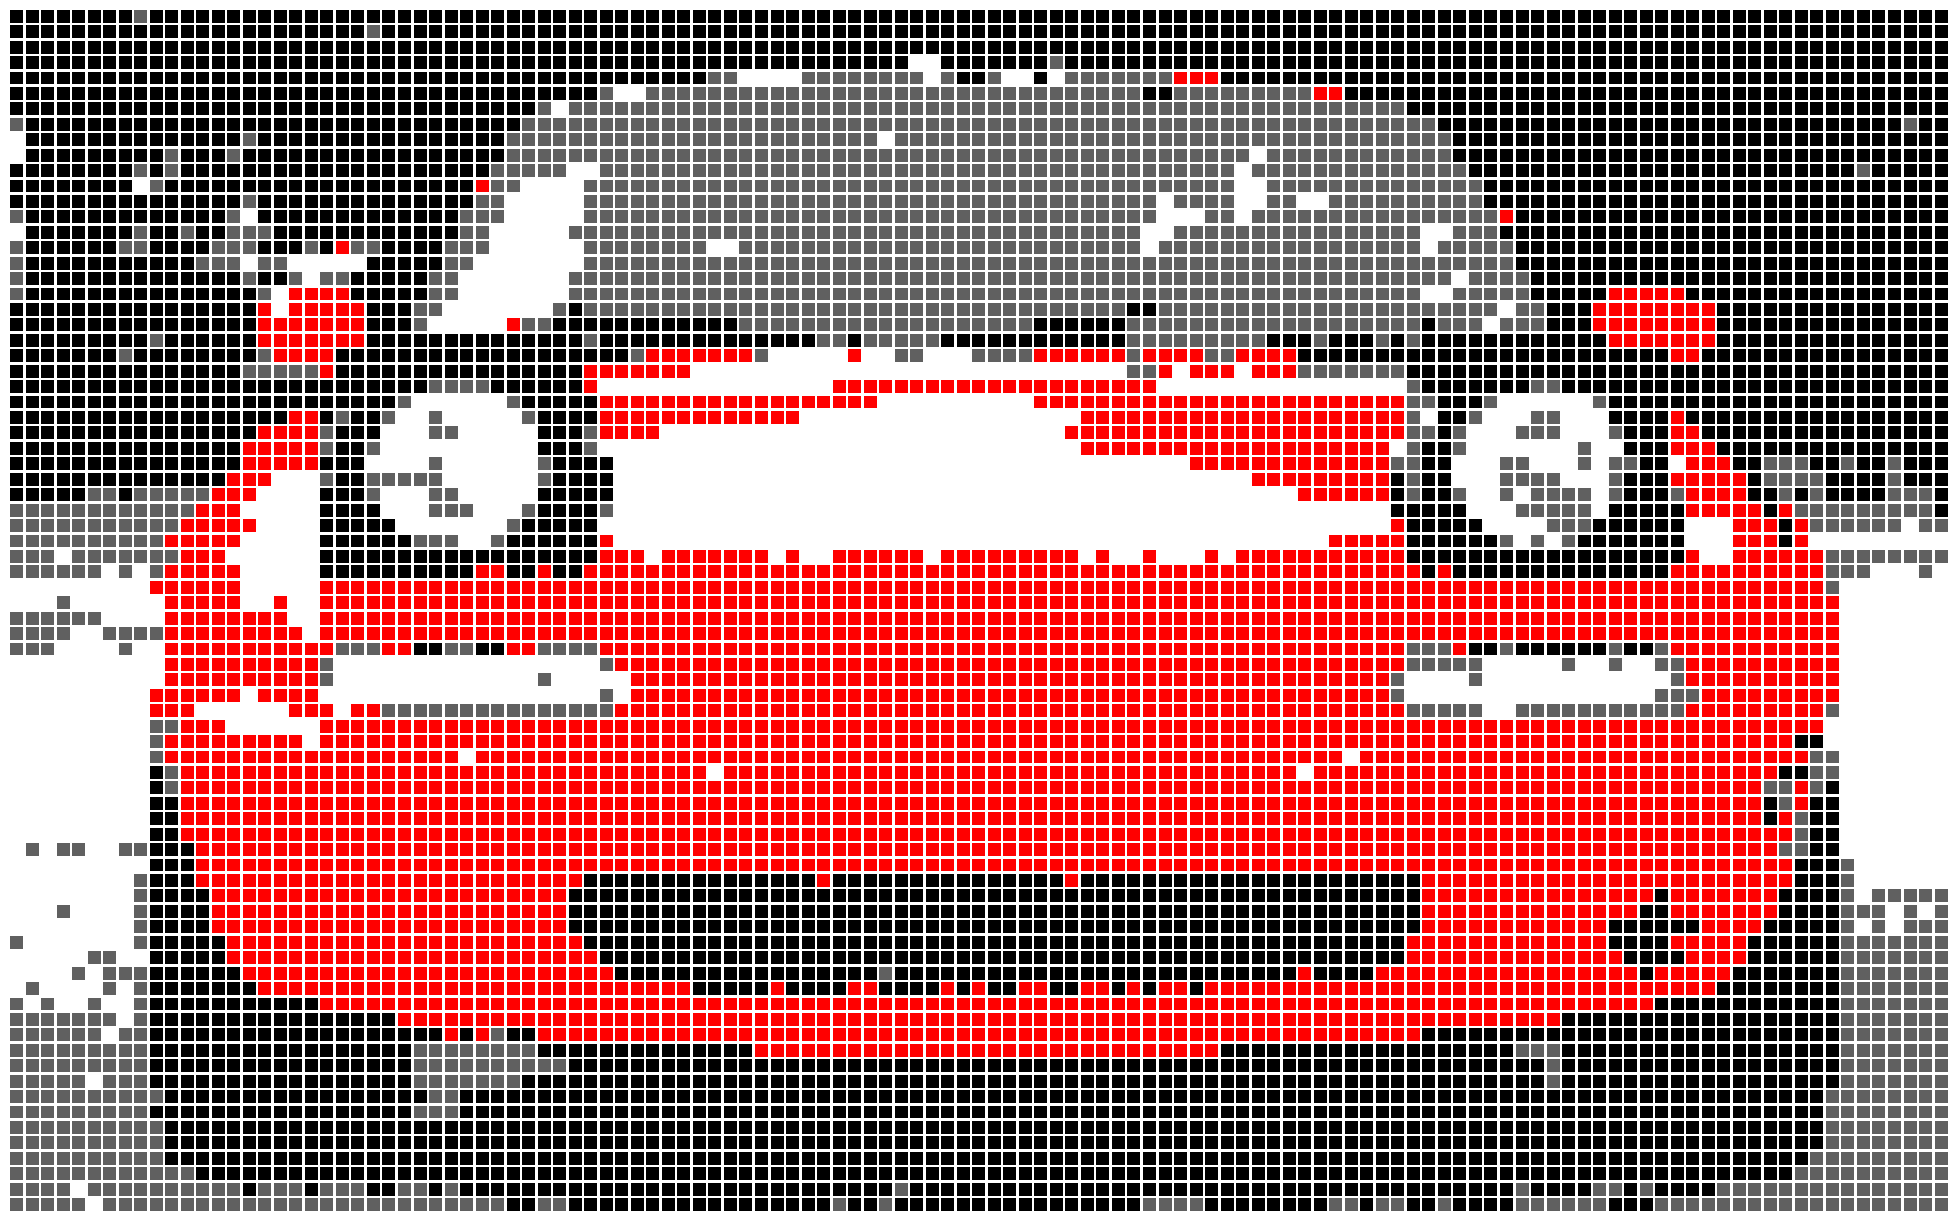

In [9]:
processed.display_reduced_colors_image(processed.resized_image,
                                       processed.grid_size,
                                       processed.image_pixelates,
                                       processed.predominant_color_mapping,
                                       new_centroids)